In [1]:
!pip install pytorch-lightning
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchmetrics

# Pytorch-Lightning : Training made Easier

Time : 4 hours

In the Tutorial session, we used PyTorch to train different models for Binary Classification. In the tutorial, few things were done :


*   We created a Training/Testing Loop and trained our models
*   We created a Trainer Class to gather all loops to perform the Training/Testing.


As you have seen, writing the training and testing loop can quickly be indigest. One can get easily lost.

Let us introduce you Pytorch Lightning

<img src="https://warehouse-camo.ingress.cmh1.psfhosted.org/a88de56e65d2ea6bc203ce178a1cecbe9b50a0ac/68747470733a2f2f6769746875622e636f6d2f5079546f7263684c696768746e696e672f7079746f7263682d6c696768746e696e672f7261772f312e342e392f646f63732f736f757263652f5f7374617469632f696d616765732f6c6f676f2e706e67">


Pytorch lightning will handle a lot of things for you. It creates a Trainer which is a Code Management trick used by many companies (Meta, Google..) in order to get much more digest code.


More Information on : https://www.pytorchlightning.ai/

Goal of this lab :

* Use Pytorch Lightning for Training
* Learn to use Pytorch-Lightning
* Do classification on MNIST, CIFAR-10


# I - Classify Numbers using Lightning

In this part, we are interested in classifying digit images ranging from 0 to 9. 
We will use the Lightning framework for code management. What's interesting about Lightning is that you can plug in your Torch modules without any modification.

## a - LightningDataModule : MNIST

As you have seen in the Tutorial, you need to create your Dataset Class.

As a reminder :    
 The Dataset class returns one sample of your dataset at a time. The main methods of the Dataset class are 

*   __getitem__ : which fetched a sample at a given index
*   __len__ : which returns the len of the total dataset

The Dataset is loaded into a DataLoader. That Dataloader is then used to **fetch and send data as batches** for your Model.

You will see that using Lightning makes things clearer. LightningDataModule allows you to write cleaner Code and fit easily your data to your model.

You can always, use the basic Pytorch Dataloader in a separate code.

We are first going to work with the MNIST dataset. There is already a MNIST class provided in the Torchvision library, so we don't have to code the Dataset implementation ourself.
* Fill in the blanks

### Exploratory Data Analysis : Discovering the Data

Before tackling the classification task it is essential to explore the data we are working on, and understand its specifics.
Perform an Exploratory Data Analysis (EDA) on the MNIST Dataset :

1.   What type of Data do you have ? (Images, Texts, Sound..)
2.   How many Data do you have ? 
3.   What's in a sample (1 element of the Dataset)
4.   Is the Dataset umbalanced ?
5.   What's the shape of any input sample ?
6.   ....



In [3]:
# Loading the Training Split of MNIST Dataset
dataset_train  = MNIST('', train=True, download=True)
dataset_test = MNIST('', train=False, download=True)

In [4]:
# TODO : What's the length of the train and test split ?
print("train set",len(dataset_train))
print("test set",len(dataset_test))

train set 60000
test set 10000


In [5]:
# TODO : Retrieve one sample of the Dataset.
sample = dataset_train.__getitem__(0)

# TODO : What is in a sample ? Print the sample to understand
print(sample)


(<PIL.Image.Image image mode=L size=28x28 at 0x226A4C51D30>, 5)


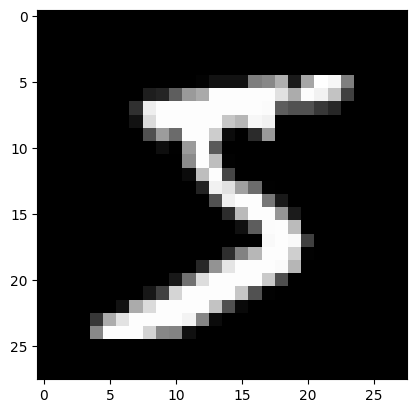

In [6]:
# TODO : Plot the image in the sample. Does it correspond to the second element of the sample ?

plt.imshow(sample[0],cmap='gray')
plt.show()

In [7]:
sample

(<PIL.Image.Image image mode=L size=28x28>, 5)

### Lightning DataModule : Dataset and DataLoader Embedded 

Pytorch Lightning introduces a new way to define and organize our dataset via "data module". They neatly encompass our training, validation and testing datasets and provide their dataloaders as well.

Have a look at : https://pytorch.org/vision/stable/datasets.html

We are now going to define a `LightningDataModule` for the MNIST dataset. 

In [8]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size_train, self.batch_size_valid, self.batch_size_test = 32,32,32

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        # TODO : Load the train and test dataset.
        MNIST(self.data_dir, train=True, download=True)
        

    def setup(self, stage):
        # We need to setup our module. We have 
        #  1. A training set that we will **fit** our model to
        #  2. A testing set used to **test** our models prediction.
        
        # The stage variable corresponds to those two steps : 
        # stage in {fit, test, None}

        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.

            # TODO : Which dataset do we load for training ?
            mnist_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            train_size = int(0.8 * len(mnist_dataset))
            test_size = len(dataset_train) - train_size
            mnist_train, mnist_valid =  torch.utils.data.random_split(mnist_dataset, [train_size, test_size])
            
            # TODO : Load the datasets as attributes of the Module. Don't forget you validation split
            self.mnist_train, _ = mnist_train.dataset, mnist_train.indices
            self.mnist_valid, _ = mnist_valid.dataset,mnist_valid.indices

        # Second stage is 'test' 
        if stage == "test" or stage is None:

            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            # Question : What additional set can we create ? Why ?
            # A : Validation set : can be used to ensure if the test set is used many times as a performance metric.
            #     At some point the test set will become a hyperparameter.
            #     The validation set is used as a true performance metric and should be used as little as possible.
        

    def train_dataloader(self):
        # TODO : Now create your Training DataLoader
        return DataLoader(self.mnist_train,batch_size=self.batch_size_train,shuffle=True)

    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        return DataLoader(self.mnist_valid,batch_size=self.batch_size_valid)

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return DataLoader(self.mnist_test,batch_size=self.batch_size_test)




In [9]:
dm = MNISTDataModule()
dm.setup('test')
test_features, test_labels = next(iter(dm.test_dataloader()))

dm.setup('fit')
train_features, train_labels = next(iter(dm.train_dataloader()))
print(train_features.size(),train_labels)

torch.Size([32, 1, 28, 28]) tensor([9, 6, 6, 4, 7, 7, 3, 9, 6, 7, 1, 4, 1, 0, 0, 2, 2, 4, 9, 5, 8, 0, 7, 5,
        3, 4, 9, 5, 2, 7, 7, 6])


The input data points are size (batch_size, 1 channel (greyscale), img_length, img_width). Their labels are randomized for the train_dataloader to prevent learning based on the data order.

## b - LightningModule :  MNIST Classifier 

Similarly to `LightningDataModule`, pytorch Lightning provides a `LightningModule` that gathers every functions needed for the training and testing of our pytorch model.
 
Design a model to perform Classification using the `LightningModule` class layout. Again, ask yourself the following questions: 
* What task is it ?
* What data do I have ?
* What learning rate should I use ?
* What could be my loss ? Why ?
* What non-linearity should I use ?
* How do I evaluate my model ? (TorchMetrics is your friend)

In [ ]:
import torchmetrics.classification
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

class MNISTClassifier(pl.LightningModule):
    def __init__(self, output_shape):
        super(MNISTClassifier,self).__init__()
        # what is the output_shape of your model ?
        # 10 classes : Nb 0->9
        self.output_shape = output_shape
        self.save_hyperparameters()
        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        self.layer_1 = nn.Linear(28*28,128)
        self.layer_2 = nn.Linear(128,output_shape)
        self.train_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.test_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.valid_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size =32
        self.acc=0
        
    def forward(self,x):
        # TODO : What would be the forward steps of this classifier ? Return the output of our classifier given an input batch x.
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.log_softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        # TODO : Choose your optimizer : https://pytorch.org/docs/stable/optim.html
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # This method is pretty much similar to what your did in the Tutorial to train your model.
        x,y = batch   
        x=self.forward(x)
        loss = F.nll_loss(x,y)
        acc = self.train_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('train_acc', acc)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,y = batch     
        x=self.forward(x)
        loss = F.nll_loss(x,y)
        
        acc = self.valid_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('val_acc', acc)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = batch    
        x=self.forward(x)
        loss = F.nll_loss(x,y)
        
       
        acc = self.test_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss)
        self.log('test_acc', acc)

    def test_epoch_start(self):
        self.acc = 0

    def on_test_epoch_end(self):
        self.log('valid_acc_epoch', self.valid_acc)
    
    """--------From Torch 2.0 Dataloaders are now part of the Lightningmodule------ Source : https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/mnist-hello-world.html----"""


    def prepare_data(self) -> None:
        """Downloads the MNIST dataset."""
        MNIST(self.data_dir, train=True, download=True)

        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str = None) -> None:
        """Splits the MNIST dataset into train, validation, and test sets.

        Args:
            stage : The current stage (either "fit" or "test"). Defaults to None.

        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            train_size = int(0.8 * len(mnist_dataset))
            test_size = len(dataset_train) - train_size
            self.mnist_train, self.mnist_valid =  torch.utils.data.random_split(mnist_dataset, [train_size, test_size])
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the training set.

        Returns:
            DataLoader: The training DataLoader.

        """
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the validation set.

        Returns:
            DataLoader: The validation DataLoader.

        """
        return DataLoader(self.mnist_valid, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the test set.

        Returns:
            DataLoader: The test DataLoader.

        """
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

NLL = negative log likelihood loss function used here, appropriate for a C class classification problem (10 classes here)
Alternative : Remove the softmax in the forward pass and use a cross entropy loss instead.
Different dataloaders are called, loading the respective train, validation and test datasets.


* Train : Calculate loss then update the weights to fit the training data
* Validation : Compute the accuracy of the model by comparing predictions to predicted labels
* Test : True performance metrics

## c - Did you say Train ?

Let's train the model. 

We create our so called Trainer that will handle a lot of thing for us. Lightning trainer is full of interesting assets that helps you for your training. The lightning trainer is a much more evolved Trainer than the one in the Tutorial.

To get a glance of what Lightning Trainer can give :
https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

It also easily lets us using TensorBoard. 

In [11]:
tb_logger = pl_loggers.TensorBoardLogger("introduction to Lightning")

model = MNISTClassifier(10)

#trainer = pl.Trainer(gpus=-1,max_epochs=10,accelerator='dp',logger=tb_logger)
trainer = pl.Trainer(max_epochs=9,accelerator='gpu',logger=tb_logger)
trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | layer_1   | Linear             | 100 K  | train
1 | layer_2   | Linear             | 1.3 K  | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | valid_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
101 K     Trainable params
0         N

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 8: 100%|██████████| 1500/1500 [00:16<00:00, 91.92it/s, v_num=5] 

`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: 100%|██████████| 1500/1500 [00:16<00:00, 91.88it/s, v_num=5]


Crash when setting num_workers =12 and persistent_workers = True as recommended

Oh it's training ! Happy ? Easy ? Let's test the model

## d - Did you say Test ?

For testing, well it's pretty easy 

In [12]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 151.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9409999847412109
        test_loss           0.29921385645866394
     valid_acc_epoch        0.9313832521438599
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.29921385645866394,
  'test_acc': 0.9409999847412109,
  'valid_acc_epoch': 0.9313832521438599}]

93% Accuracy is an acceptable first result.

## e - TensorBoard

TensorBoard is a really useful tool. Indeed, it let's you register interesting values during training and plot them INTERACTIVELY. You might have seen a self.log line in the Validation and Training steps. 
The self.log saves the loss value into a TensorBoard readable file. We can also add images or other values using self.log

In fact, look at the checkpoint created by the training. You might see 3 files :
* Checkpoint
* event.out....
* hparam.yaml

Let's open tensorboard to see how the training was. Tensorboard is loadable using magic_python commands.
More info on TensorBoard : https://www.tensorflow.org/tensorboard/get_started

Another popular alternative to Tensorboard, also usable with pytorch lightning, is "Weight and Biases".

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/introduction to Lightning/lightning_logs/version_1"

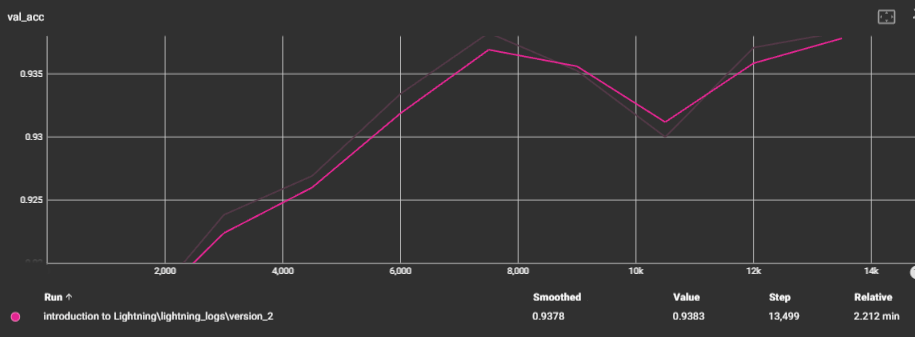

I find the tensorboard window easier to use.

Pytorch Lightning can be used along PyTorch. We encourage you to use PyTorch Lightning during your Lab Sessions and Career as it simplifies a lot of things for you (MultiGPU, Learning Rate Decay...)

<img src='https://c.tenor.com/VyApQ-jWyV0AAAAC/happy-borat.gif'>



# II - Classify Objects using Lightning 

We will now turn to another classification task, this time object classification. We use the CIFAR-10 dataset which is made of 10 different classes of objects which we aim to distinguish. This part of the lab will be less restricted and more free. You now should have a sense of how to use the Lightning Framework. 
Be creative.


## a - Baseline : Creating your own Model

In this first section, we will create a Simple Model and perform all steps from part 1 with the needed changes.

*   **What's your final accuracy ?**


### i - DataModule

In [14]:
import torchvision
import numpy
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# TODO : EDA 
sample = trainset.__getitem__(0)

In [16]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [17]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


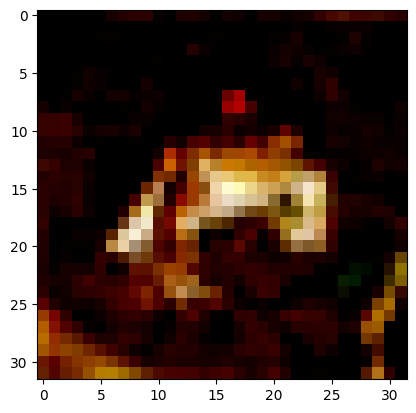

6


In [18]:
import numpy as np
plt.imshow(np.transpose(sample[0], (1, 2, 0)))
plt.show()
print(sample[1])

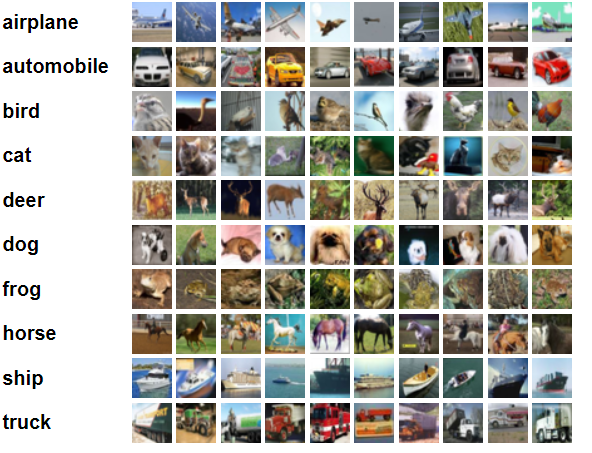

According to the doc label 6 should be frog (targets 0 ->9)

In [19]:
# TODO : Create your DataModule

As mentioned previousely, the datamodule is built in the lighning module

### ii - Module

In [ ]:
# TODO : Create your Module
import torchmetrics.classification
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, output_shape):
        super(CIFAR10Classifier,self).__init__()
        # what is the output_shape of your model ?
        # 10 classes : Nb 0->9
        self.output_shape = output_shape
        self.save_hyperparameters()
        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_shape)
        self.train_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.test_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.valid_acc =torchmetrics.classification.Accuracy(task="multiclass",num_classes=10)
        self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.data_dir = ''
        self.batch_size =32
        self.acc=0
        
    def forward(self,x):
        # TODO : What would be the forward steps of this classifier ? Return the output of our classifier given an input batch x.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def configure_optimizers(self):
        # TODO : Choose your optimizer : https://pytorch.org/docs/stable/optim.html
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # This method is pretty much similar to what your did in the Tutorial to train your model.
        x,y = batch   
        x=self.forward(x)
        loss = F.cross_entropy(x,y)
        acc = self.train_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('train_acc', acc)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,y = batch     
        x=self.forward(x)
        loss = F.cross_entropy(x,y)
        
        acc = self.valid_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('val_acc', acc)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = batch    
        x=self.forward(x)
        loss = F.cross_entropy(x,y)
        
       
        acc = self.test_acc(x,y)
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss)
        self.log('test_acc', acc)

    def test_epoch_start(self):
        self.acc = 0

    def on_test_epoch_end(self):
        self.log('valid_acc_epoch', self.valid_acc)
    
    """--------From Torch 2.0 Dataloaders are now part of the Lightningmodule----------"""


    def prepare_data(self) -> None:
        """Downloads the MNIST dataset.   Here loads from memory, useful on local after a crash"""
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

    def setup(self, stage: str = None) -> None:
        """Splits the MNIST dataset into train, validation, and test sets.

        Args:
            stage : The current stage (either "fit" or "test"). Defaults to None.

        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
            train_size = int(0.8 * len(trainset))
            test_size = len(trainset) - train_size
            self.trainset, self.validset =  torch.utils.data.random_split(trainset, [train_size, test_size])
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
    def train_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the training set.

        Returns:
            DataLoader: The training DataLoader.

        """
        return DataLoader(self.trainset, batch_size=self.batch_size)

    def val_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the validation set.

        Returns:
            DataLoader: The validation DataLoader.

        """
        return DataLoader(self.validset, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the test set.

        Returns:
            DataLoader: The test DataLoader.

        """
        return DataLoader(self.testset, batch_size=self.batch_size)

For this 3D image problem, using a few conv layers for feature extraction then using classification layers should yield results.

### iii - Train

In [21]:
# TODO : Train
tb_logger = pl_loggers.TensorBoardLogger("CIFAR10_test")

model = CIFAR10Classifier(10)

#trainer = pl.Trainer(gpus=-1,max_epochs=10,accelerator='dp',logger=tb_logger)
trainer = pl.Trainer(max_epochs=10,accelerator='gpu',logger=tb_logger)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 456    | train
1 | pool      | MaxPool2d          | 0      | train
2 | conv2     | Conv2d             | 2.4 K  | train
3 | fc1       | Linear             | 48.1 K | train
4 | fc2       | Linear             | 10.2 K | train
5 | fc3       | Linear             | 850    | train
6 | train_acc | MulticlassAccuracy | 0      | train
7 | test_acc  | MulticlassAccuracy | 0      | train
8 | valid_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1250/1250 [00:21<00:00, 58.75it/s, v_num=8]      

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1250/1250 [00:21<00:00, 58.72it/s, v_num=8]


### iv - Test

In [22]:
# TODO : Test
trainer.test(model)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 108.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3515999913215637
        test_loss           1.6986732482910156
     valid_acc_epoch        0.3213343322277069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6986732482910156,
  'test_acc': 0.3515999913215637,
  'valid_acc_epoch': 0.3213343322277069}]


**Does your model perform well on the CIFAR Dataset ?**




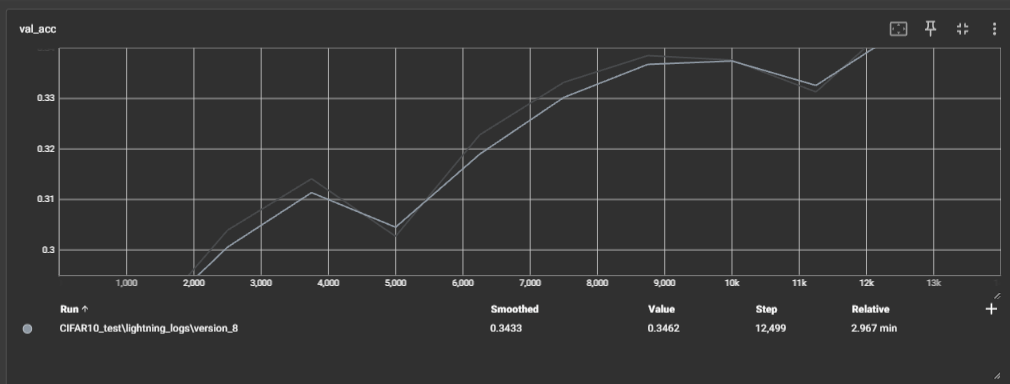

This particular model doesn't perform as well as I hoped, the val_accuracy reaches about 32%. The training doesn't look finished but I decided to stop there after experiencing some crashes when tweaking the training parameters.

# Conclusions 
This TP was a god tutorial for pytorch and most importantly how to setup and update torch instances.
* Local / Colab torch setup https://pytorch.org/get-started/locally/ . 
There were some issues with deprecated function like test_epoch_end -> on_test_epoch_end which causes breaking issues https://github.com/Lightning-AI/pytorch-lightning/pull/16567
* Torch version >2.0 using the dataloaders in the torch lightning class https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/mnist-hello-world.html

* Torch ligtning is useful for dealing with bloat code, and focus on the model characteristics. I will certainly use it in future projects.

* Finetuning not implemented 
The process is an application of transfer learning where a pretrained model is used for its learning / classification capabilities and its lowest layers (classifiers) are retrained on the specified dataset. This way we can leverage the pretrained model's learning abilities and apply them to the dataset to archieve a better accuracy.

## b - The OG Model : Finetuning a Model                NOT DONE

If your model performed well on the CIFAR-10 Dataset, congrats. But let's achieve better results. For industrial works, we often pretrain a model on a large dataset (ImageNet or internal Dataset), and then fine-tune the model on the Dataset of interest.

* **What's the intuition behind fine-tuning ?**

### i - Importing a Pretrained Model

We will import a ConvNext model. Why ? It's said to be a really good backbone that competes with the Transformer models. Let's load the model. 
We are going to use TorchSummary to print what the size of the inputs and outputs are.

In [23]:

import torchvision
model = torchvision.models.convnext_small(weights='DEFAULT')

# TODO : Using torchsummary, print a summary of the model
from torchsummary import summary
summary(model)


Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to C:\Users\JERM/.cache\torch\hub\checkpoints\convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:14<00:00, 14.3MB/s] 


Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       4,704
|    |    └─LayerNorm2d: 3-2                  192
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      79,296
|    |    └─CNBlock: 3-4                      79,296
|    |    └─CNBlock: 3-5                      79,296
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  192
|    |    └─Conv2d: 3-7                       73,920
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      306,048
|    |    └─CNBlock: 3-9                      306,048
|    |    └─CNBlock: 3-10                     306,048
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 384
|    |    └─Conv2d: 3-12                      295,296
|    └─Sequential: 2-6

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       4,704
|    |    └─LayerNorm2d: 3-2                  192
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      79,296
|    |    └─CNBlock: 3-4                      79,296
|    |    └─CNBlock: 3-5                      79,296
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  192
|    |    └─Conv2d: 3-7                       73,920
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      306,048
|    |    └─CNBlock: 3-9                      306,048
|    |    └─CNBlock: 3-10                     306,048
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 384
|    |    └─Conv2d: 3-12                      295,296
|    └─Sequential: 2-6

In [24]:
# TODO : Using torchsummary, send an image of the same size as a sample of CIFAR-10
summary(model, ...) # ... = input shape as a tuple (C,H,W)


TypeError: Input type is not recognized. Please ensure input_data is valid.
For multiple inputs to the network, ensure input_data passed in is a sequence of tensors or a list of tuple sizes. If you are having trouble here, please submit a GitHub issue.

* **What is the output size of the model ?**
* **What will be the issue of using this model as is to perform classification on the CIFAR-10 Dataset ?**


In [ ]:
# TODO : According to your answer to the previous questions, perform the changes.
# You can access each layers using model.name_of_layer

### ii - DataModule

In [ ]:
# TODO : EDA 

# TODO : Create your DataModule

### iii - Module



In [ ]:
# TODO : Create your Module

# Careful : How should your learning rate be ?

### iv - Train

In [ ]:
# TODO : Train

### v - Test

In [ ]:
# TODO : Test


* **What is your final accuracy ?**
* **Is Fine Tuning a model better than creating your own model ?**